In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from fastai.vision import *

In [3]:
path = Path('/content/gdrive/MyDrive/fastai/Animal/')

In [ ]:
for file, folder in [('cats.csv', 'Cats'), ('dogs.csv', 'Dogs'), ('horse.csv', 'Horses')]:
    dest = path/folder # path + '/' + folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(path/file, dest, max_pics=50)

In [ ]:
doc(verify_images)

In [4]:
for folder in ('Cats', 'Dogs', 'Horses'):
    print(folder)
    verify_images(path/folder, delete=True, max_size=50)

Cats


Dogs


Horses


In [5]:
# Load data
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct = 0.2,
                                  ds_tfms = get_transforms(), size = 224, num_workers = 4).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
data.classes

['Cats', 'Dogs', 'Horses']

In [7]:
doc(data.show_batch)

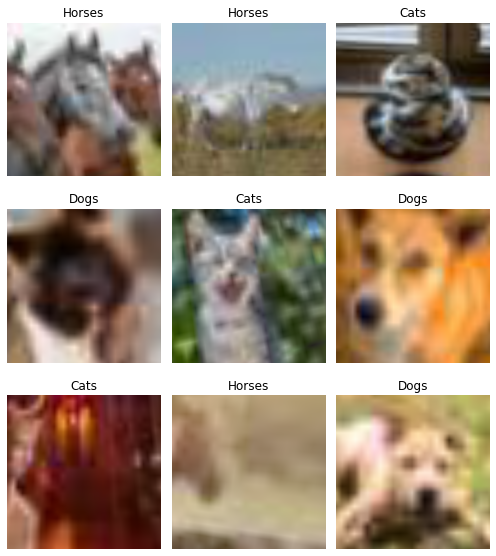

In [8]:
data.show_batch(rows=3, figsize=(7, 8))

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Cats', 'Dogs', 'Horses'], 3, 70, 17)

In [10]:
## Training

from fastai.metrics import error_rate
learn = create_cnn(data, models.resnet34, metrics = error_rate)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [11]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (70 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Cats,Cats,Cats,Cats,Cats
Path: /content/gdrive/MyDrive/fastai/Animal;

Valid: LabelList (17 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Dogs,Cats,Cats,Cats,Cats
Path: /content/gdrive/MyDrive/fastai/Animal;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

In [12]:
doc(learn.fit_one_cycle)

In [13]:
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.837025,2.385574,0.647059,00:02
1,1.940869,2.177046,0.470588,00:01
2,1.674830,2.475106,0.529412,00:01
3,1.525849,2.317804,0.647059,00:01


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
learn.unfreeze()

In [15]:
learn.lr_find()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


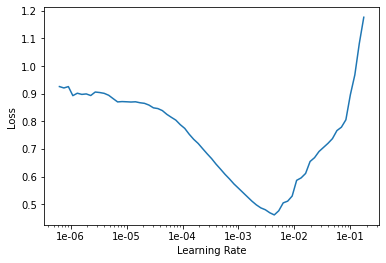

In [16]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(6, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.859391,1.964775,0.529412,00:01
1,0.846755,1.757586,0.470588,00:01
2,0.886943,1.589972,0.470588,00:01
3,0.845280,1.477144,0.411765,00:01
4,0.827134,1.395508,0.411765,00:01
5,0.791912,1.374407,0.411765,00:01


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
learn.save('animal-detection-stage-1')

In [21]:
from fastai.widgets import *

In [22]:
doc(DatasetFormatter().from_toplosses)

In [23]:
ds, idxs = DatasetFormatter().from_toplosses(learn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [24]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [25]:
df = pd.read_csv(path/'cleaned.csv', header='infer')
df.head()

,name,label
0,Cats/00000009.jpg,Cats
1,Cats/00000007.jpg,Cats
2,Cats/00000000.jpg,Cats
3,Cats/00000006.jpg,Cats
4,Cats/00000008.jpg,Cats


In [26]:
df[(df['name'].apply(lambda x: len(x)<5))]

,name,label


In [34]:
np.random.seed(42)
db = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [35]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Cats', 'Dogs', 'Horses'], 3, 70, 17)

In [36]:
db.classes, db.c, len(db.train_ds), len(db.valid_ds)

(['Cats', 'Dogs', 'Horses'], 3, 70, 17)

In [37]:
learn.data = db

In [38]:
learn.freeze()
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.335558,1.317855,0.352941,00:01
1,0.441904,1.176552,0.294118,00:01
2,0.447702,1.220117,0.352941,00:01
3,0.483672,1.265965,0.411765,00:01


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [39]:
learn.unfreeze()

In [40]:
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.499941,1.293019,0.411765,00:01
1,0.485237,1.195482,0.352941,00:01
2,0.458765,1.193770,0.294118,00:01
3,0.413287,1.206524,0.294118,00:01


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [41]:
learn.save('animal-detection-stage-2')

In [42]:
interp = ClassificationInterpretation.from_learner(learn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


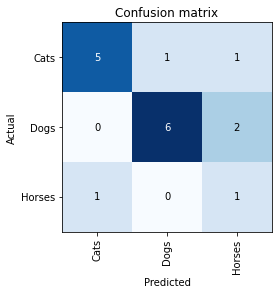

In [43]:
interp.plot_confusion_matrix()

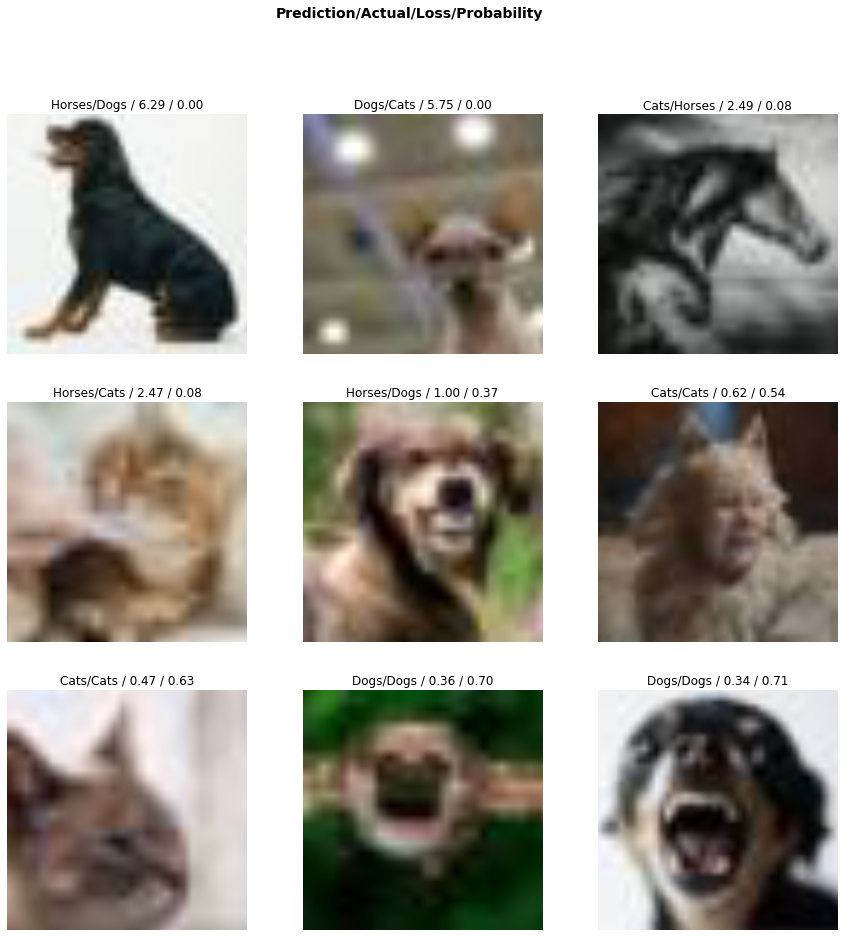

In [44]:
interp.plot_top_losses(9, figsize=(15,15))